In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jan 13 12:41:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from enum import Enum
import imageio
import os

%matplotlib inline
plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format='retina'

dtype = 'float32'
tf.keras.backend.set_floatx(dtype)

In [6]:
################################################################################
# DATASETS
################################################################################


class Dataset:
    def __init__(self, X_train, y_train, X_test, y_test, shape, shape_flattened):
        X_train = X_train.astype(dtype) / 255.0
        y_train = y_train.astype(dtype)
        X_test = X_test.astype(dtype)  / 255.0
        y_test = y_test.astype(dtype)

        X_train = np.reshape(X_train, shape_flattened)
        X_test = np.reshape(X_test, shape_flattened)

        X = np.concatenate((X_train, X_test), axis=0)
        y = np.concatenate((y_train, y_test), axis=0)

        from sklearn.preprocessing import StandardScaler

        scaler = StandardScaler()
        scaler.fit(X_train)  # Scaling each feature independently

        X_norm = scaler.transform(X)
        X_train_norm = scaler.transform(X_train)
        X_test_norm = scaler.transform(X_test)

        X_norm = np.reshape(X_norm, shape)
        X_train_norm = np.reshape(X_train_norm, shape)
        X_test_norm = np.reshape(X_test_norm, shape)

        self.X_norm = X_norm
        self.y = y
        self.X_train_norm = X_train_norm
        self.y_train = y_train
        self.X_test_norm = X_test_norm
        self.y_test = y_test


def get_cifar_10_dataset():
    cifar10 = tf.keras.datasets.cifar10
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    shape = (-1, 32, 32, 3)
    shape_flattened = (-1, 3072)  # Scaling each feature independently
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened)


def get_cifar_100_dataset():
    cifar100 = tf.keras.datasets.cifar100
    (X_train, y_train), (X_test, y_test) = cifar100.load_data()
    shape = (-1, 32, 32, 3)
    shape_flattened = (-1, 3072)  # Scaling each feature independently
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened)


def get_svhn_dataset():
    from scipy import io

    X_train = io.loadmat(train_filename, variable_names='X').get('X')
    y_train = io.loadmat(train_filename, variable_names='y').get('y')
    X_test = io.loadmat(test_filename, variable_names='X').get('X')
    y_test = io.loadmat(test_filename, variable_names='y').get('y')

    X_train = np.moveaxis(X_train, -1, 0)
    y_train -= 1
    X_test = np.moveaxis(X_test, -1, 0)
    y_test -= 1

    shape = (-1, 32, 32, 3)
    shape_flattened = (-1, 3072)  # Scaling each feature independently
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened)


def get_tiny_imagenet_dataset():
    """
    Original source: https://github.com/sonugiri1043/Train_ResNet_On_Tiny_ImageNet/blob/master/Train_ResNet_On_Tiny_ImageNet.ipynb
    Original author: sonugiri1043@gmail.com
    """

    if not os.path.isdir('IMagenet'):
        ! git clone https://github.com/seshuad/IMagenet

    print("Processing the downloaded dataset...")

    path = 'IMagenet/tiny-imagenet-200/'

    id_dict = {}
    for i, line in enumerate(open(path + 'wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i

    train_data = list()
    test_data = list()
    train_labels = list()
    test_labels = list()

    for key, value in id_dict.items():
        train_data += [imageio.imread(path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i)), pilmode='RGB') for i in range(500)]
        train_labels_ = np.array([[0]*200]*500)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()

    for line in open(path + 'val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(imageio.imread(path + 'val/images/{}'.format(img_name), pilmode='RGB'))
        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    X_train = np.array(train_data)
    y_train = np.argmax(np.array(train_labels), axis=1)
    X_test = np.array(test_data)
    y_test = np.argmax(np.array(test_labels), axis=1)

    shape = (-1, 64, 64, 3)
    shape_flattened = (-1, 12288)  # Scaling each feature independently
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened)


def get_mnist_dataset():
    mnist = tf.keras.datasets.mnist
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    shape = (-1, 28, 28, 1)
    shape_flattened = (-1, 1)  # Scaling all features together
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened)


def get_fashion_mnist_dataset():
    fashion_mnist = tf.keras.datasets.fashion_mnist
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    shape = (-1, 28, 28, 1)
    shape_flattened = (-1, 1)  # Scaling all features together
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened)


################################################################################
# REGULARIZERS
################################################################################


class Regularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, regularization_penalty, regularization_method):
        self.regularization_penalty = regularization_penalty
        self.regularization_method = regularization_method
        self.n_new_neurons = 0
        self.scaling_tensor = None
        if self.regularization_method == 'weighted_l1_reordered':
            self.update_scaling_tensor = True
        else:
            self.update_scaling_tensor = None

    def __call__(self, x):
        if self.regularization_method == 'weighted_l1':
            return self.weighted_l1(x)
        elif self.regularization_method == 'weighted_l1_reordered':
            return self.weighted_l1_reordered(x)
        elif self.regularization_method == 'group_sparsity':
            return self.group_sparsity(x)
        elif self.regularization_method == 'l1':
            return self.l1(x)
        else:
            raise NotImplementedError(f"Unknown regularization method {self.regularization_method}")
    
    def weighted_l1(self, x):
        # I.e. for a parameter matrix of 4 input and 10 output neurons:
        #
        # [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]
        #
        # the scaling tensor, as well as the resulting weighted values, could be:
        #
        # [[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]]
        #
        # Therefore every additional output neuron is regularized more.

        scaling_tensor = tf.cumsum(tf.constant(self.regularization_penalty, shape=x.shape, dtype=dtype), axis=-1)
        weighted_values = scaling_tensor * tf.abs(x)
        return tf.reduce_sum(weighted_values)
    
    def weighted_l1_reordered(self, x):
        # I.e. for a parameter matrix of 4 input and 10 output neurons:
        #
        # [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]
        #
        # the scaling tensor, as well as the resulting weighted values, could be:
        #
        # [[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]]
        #
        # Therefore every additional output neuron is regularized more.

        if self.update_scaling_tensor:
            scaling_tensor_raw = tf.cumsum(tf.constant(self.regularization_penalty, shape=x.shape, dtype=dtype), axis=-1)

            scaling_tensor_old_neurons = scaling_tensor_raw[:, :-self.n_new_neurons]
            scaling_tensor_new_neurons = scaling_tensor_raw[:, -self.n_new_neurons:]
            scaling_tensor_old_neurons_shuffled = tf.transpose(tf.random.shuffle(tf.transpose(scaling_tensor_old_neurons)))
            self.scaling_tensor = tf.concat([scaling_tensor_old_neurons_shuffled, scaling_tensor_new_neurons], axis=-1)
            self.update_scaling_tensor = False

        weighted_values = self.scaling_tensor * tf.abs(x)
        return tf.reduce_sum(weighted_values)
    
    def group_sparsity(self, x):
        # I.e. for a parameter matrix of 3 input and 5 output neurons:
        #
        # [[1., 1., 1., 1., 1.],
        #  [1., 2., 2., 1., 2.],
        #  [2., 2., 3., 1., 3.]]
        #
        # The resulting vector of group norms is [2., 2., 3., 1., 3.], therefore for
        # every output neuron, its incoming connections form a group.

        group_norms = tf.norm(x, ord=2, axis=0)
        # assert group_norms.shape[0] == x.shape[1]
        return self.regularization_penalty * tf.reduce_sum(group_norms)
    
    def l1(self, x):
        weighted_values = self.regularization_penalty * tf.abs(x)
        return tf.reduce_sum(weighted_values)
    
    def prune(self):
        self.n_new_neurons = 0
        if self.regularization_method == 'weighted_l1_reordered':
            self.update_scaling_tensor = True
    
    def grow(self, n_new_neurons):
        self.n_new_neurons = n_new_neurons
        if self.regularization_method == 'weighted_l1_reordered':
            self.update_scaling_tensor = True

    def get_config(self):
        return {'regularization_penalty': float(self.regularization_penalty)}


################################################################################
# LAYERS
################################################################################


class CustomLayer(tf.keras.layers.Layer):
    def __init__(self, input_shape):
        super().__init__()

        self.inpt_shp = input_shape


class Dense(CustomLayer):
    def __init__(self, units, activation, regularization_penalty=0.01, 
                 regularization_method='weighted_l1', kernel_initializer='glorot_uniform', 
                 bias_initializer='zeros', input_shape=None, fixed_size=False):
        super().__init__(input_shape)

        self.units = units
        self.activation = activation
        self.regularization_penalty = regularization_penalty
        self.regularization_method = regularization_method
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.fixed_size = fixed_size
        
        self.A = tf.keras.activations.get(activation)
        self.W_init = tf.keras.initializers.get(kernel_initializer)
        self.b_init = tf.keras.initializers.get(bias_initializer)
        self.regularizer = Regularizer(self.regularization_penalty, self.regularization_method)
    
    def build(self, input_shape):
        input_units = input_shape[-1]

        self.W = tf.Variable(
            name='W',
            initial_value=self.W_init(shape=(input_units, self.units), dtype=dtype),
            trainable=True)
        
        self.b = tf.Variable(
            name='b',
            initial_value=self.b_init(shape=(self.units,), dtype=dtype),
            trainable=True)
        
        if self.regularization_method is not None:
            self.add_loss(lambda: self.regularizer(tf.concat([self.W, tf.reshape(self.b, (1, -1))], axis=0)))
    
    def call(self, inputs, training=None):
        return self.A(tf.matmul(inputs, self.W) + self.b)

    def get_size(self):
        return self.W.shape[0], self.W.shape[1]
    
    def prune(self, threshold, active_input_units_indices):
        # Remove connections from pruned units in previous layer
        new_W = tf.gather(self.W.value(), active_input_units_indices, axis=0)

        if self.fixed_size:
            active_output_neurons_indices = list(range(new_W.shape[1]))
        else:
            # Prune units in this layer
            weights_with_biases = tf.concat([new_W, tf.reshape(self.b.value(), (1, -1))], axis=0)
            neurons_are_active = tf.math.reduce_max(tf.abs(weights_with_biases), axis=0) >= threshold
            active_output_neurons_indices = tf.reshape(tf.where(neurons_are_active), (-1,))
            
            new_W = tf.gather(new_W, active_output_neurons_indices, axis=1)
            new_b = tf.gather(self.b.value(), active_output_neurons_indices, axis=0)

            self.b = tf.Variable(name='b', initial_value=new_b, trainable=True)

        self.W = tf.Variable(name='W', initial_value=new_W, trainable=True)

        self.regularizer.prune()
        return active_output_neurons_indices
    
    def grow(self, n_new_input_units, percentage, min_new_units, scaling_factor):
        if n_new_input_units > 0:
            # Add connections to grown units in previous layer
            W_growth = self.W_init(shape=(self.W.shape[0] + n_new_input_units, self.W.shape[1]), dtype=dtype)[-n_new_input_units:, :] * scaling_factor  # TODO is it better to be multiplying here by scaling_factor? It does help with not increasing the max weights of existing neurons when new neurons are added.
            new_W = tf.concat([self.W.value(), W_growth], axis=0)
        else:
            new_W = self.W.value()

        if self.fixed_size:
            n_new_output_units = 0
        else:
            # Grow new units in this layer
            n_new_output_units = max(min_new_units, int(new_W.shape[1] * percentage))
            if n_new_output_units > 0:
                W_growth = self.W_init(shape=(new_W.shape[0], new_W.shape[1] + n_new_output_units), dtype=dtype)[:, -n_new_output_units:] * scaling_factor
                b_growth = self.b_init(shape=(n_new_output_units,), dtype=dtype)  # TODO for all possible bias initializers to work properly, the whole bias vector should be initialized at once
                new_W = tf.concat([new_W, W_growth], axis=1)
                new_b = tf.concat([self.b.value(), b_growth], axis=0)

                self.b = tf.Variable(name='b', initial_value=new_b, trainable=True)

        self.W = tf.Variable(name='W', initial_value=new_W, trainable=True)

        self.regularizer.grow(n_new_output_units)
        return n_new_output_units
    
    def get_param_string():
        param_string = ""
        weights_with_bias = tf.concat([self.W, tf.reshape(self.b, (1, -1))], axis=0)
        max_parameters = tf.math.reduce_max(tf.abs(weights_with_bias), axis=0).numpy()
        magnitudes = np.floor(np.log10(max_parameters))
        for m in magnitudes:
            if m > 0:
                m = 0
            param_string += str(int(-m))
        return param_string


class Conv2D(CustomLayer):
    def __init__(self, filters, filter_size, activation, strides=(1, 1), 
                 padding='SAME', regularization_penalty=0.01, 
                 regularization_method='weighted_l1', kernel_initializer='glorot_uniform',
                 bias_initializer='zeros', input_shape=None, fixed_size=False):
        super().__init__(input_shape)
    
        self.filters = filters
        self.filter_size = filter_size
        self.activation = activation
        self.strides = strides
        self.padding = padding
        self.regularization_penalty = regularization_penalty
        self.regularization_method = regularization_method
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.fixed_size = fixed_size
        
        self.A = tf.keras.activations.get(activation)
        self.F_init = tf.keras.initializers.get(kernel_initializer)
        self.b_init = tf.keras.initializers.get(bias_initializer)
        self.regularizer = Regularizer(self.regularization_penalty, self.regularization_method)
    
    def build(self, input_shape):
        input_filters = input_shape[-1]

        self.F = tf.Variable(
            name='F',
            initial_value=self.F_init(
                shape=(self.filter_size[0], self.filter_size[1], input_filters, self.filters), dtype=dtype
            ),
            trainable=True)
        
        self.b = tf.Variable(
            name='b',
            initial_value=self.b_init(shape=(self.filters,), dtype=dtype),
            trainable=True)

        if self.regularization_method is not None:
            self.add_loss(lambda: self.regularizer(tf.concat([tf.reshape(self.F, (-1, self.F.shape[-1])), tf.reshape(self.b, (1, -1))], axis=0)))
    
    def call(self, inputs, training=None):
        y = tf.nn.conv2d(inputs, self.F, strides=self.strides, padding=self.padding)
        y = tf.nn.bias_add(y, self.b)
        y = self.A(y)
        return y
    
    def get_size(self):
        return self.F.shape[-2], self.F.shape[-1]
    
    def prune(self, threshold, active_input_units_indices):
        # Remove connections from pruned units in previous layer
        new_F = tf.gather(self.F.value(), active_input_units_indices, axis=-2)

        if self.fixed_size:
            active_output_filters_indices = list(range(new_F.shape[-1]))
        else:
            # Prune units in this layer
            F_reduced_max = tf.reshape(tf.math.reduce_max(tf.abs(new_F), axis=(0, 1, 2)), (1, -1))
            F_reduced_max_with_biases = tf.concat([F_reduced_max, tf.reshape(self.b.value(), (1, -1))], axis=0)
            filters_are_active = tf.math.reduce_max(tf.abs(F_reduced_max_with_biases), axis=0) >= threshold
            active_output_filters_indices = tf.reshape(tf.where(filters_are_active), (-1,))
            
            new_F = tf.gather(new_F, active_output_filters_indices, axis=-1)
            new_b = tf.gather(self.b.value(), active_output_filters_indices, axis=0)

            self.b = tf.Variable(name='b', initial_value=new_b, trainable=True)

        self.F = tf.Variable(name='F', initial_value=new_F, trainable=True)

        self.regularizer.prune()
        return active_output_filters_indices

    def grow(self, n_new_input_units, percentage, min_new_units, scaling_factor):
        if n_new_input_units > 0:
            # Add connections to grown units in previous layer
            F_growth = self.F_init(shape=(self.F.shape[0], self.F.shape[1], self.F.shape[2] + n_new_input_units, self.F.shape[3]), dtype=dtype)[:, :, -n_new_input_units:, :] * scaling_factor  # TODO is it better to be multiplying here by scaling_factor? It does help with not increasing the max weights of existing neurons when new neurons are added.
            new_F = tf.concat([self.F.value(), F_growth], axis=-2)
        else:
            new_F = self.F.value()

        if self.fixed_size:
            n_new_output_units = 0
        else:
            # Grow new units in this layer
            n_new_output_units = max(min_new_units, int(new_F.shape[-1] * percentage))
            if n_new_output_units > 0:
                F_growth = self.F_init(shape=(new_F.shape[0], new_F.shape[1], new_F.shape[2], new_F.shape[3] + n_new_output_units), dtype=dtype)[:, :, :, -n_new_output_units:] * scaling_factor
                b_growth = self.b_init(shape=(n_new_output_units,), dtype=dtype)  # TODO for all possible bias initializers to work properly, the whole bias vector should be initialized at once
                new_F = tf.concat([new_F, F_growth], axis=-1)
                new_b = tf.concat([self.b.value(), b_growth], axis=0)

                self.b = tf.Variable(name='b', initial_value=new_b, trainable=True)

        self.F = tf.Variable(name='F', initial_value=new_F, trainable=True)

        self.regularizer.grow(n_new_output_units)
        return n_new_output_units

    def get_param_string():
        param_string = ""
        # TODO
        return param_string


class Flatten(tf.keras.Model):
    def call(self, inputs, training=None):
        return tf.reshape(tf.transpose(inputs, perm=[0, 3, 1, 2]), (inputs.shape[0], -1))


################################################################################
# MODELS
################################################################################


class EpochType(Enum):
    DYNAMIC = 0
    STATIC_WITH_REGULARIZATION = 1
    STATIC_NO_REGULARIZATION = 2
    PRUNING_ONLY = 3
    GROWTH_ONLY = 4

    def __repr__(self):
        return str(self.value)


class Schedule:
    def __init__(self, epoch_types):
        self.epoch_types = epoch_types

    def __iter__(self):
        return self.epoch_types.__iter__()
    
    def __len__(self):
        return len(self.epoch_types)
    
    def __str__(self):
        return ''.join([str(epoch_type.value) for epoch_type in self.epoch_types])
    
    def __repr__(self):
        return self.__str__()


class Sequential(tf.keras.Model):
    def __init__(self, layers, activation=None):
        super().__init__()
        
        self.lrs = layers
        
    def call(self, inputs, training=None):
        x = inputs
        for layer in self.lrs:
            x = layer(x, training=training)
        return x
    
    def get_layer_input_shape(self, target_layer):
        if target_layer.inpt_shp is not None:
            return target_layer.inpt_shp

        input = np.random.normal(size=(1,) + self.lrs[0].inpt_shp)
        for layer in self.lrs:
            if layer is target_layer:
                return tuple(input.shape[1:])
            input = layer(input)
        raise Exception("Layer not found in the model.")

    def get_layer_output_shape(self, target_layer):
        input = np.random.normal(size=(1,) + self.lrs[0].inpt_shp)
        for layer in self.lrs:
            output = layer(input)
            if layer is target_layer:
                return tuple(output.shape[1:])
            input = output
        raise Exception("Layer not found in the model.")
    
    def get_layer_sizes(self):
        """
        Returns the sizes of all layers in the model, including the input and output layer.
        """
        layer_sizes = list()
        first_layer = True
        for l in range(len(self.lrs)):
            layer = self.lrs[l]
            if isinstance(layer, CustomLayer):
                layer_size = layer.get_size()
                if first_layer:
                    layer_sizes.append(layer_size[0])
                    first_layer = False
                layer_sizes.append(layer_size[1])
        return layer_sizes
    
    def get_hidden_layer_sizes(self):
        return self.get_layer_sizes()[1:-1]
    
    def get_regularization_penalty(self):
        #TODO improve
        return self.lrs[-2].regularizer.regularization_penalty
    
    def set_regularization_penalty(self, regularization_penalty):
        for layer in self.lrs:
            if isinstance(layer, CustomLayer) and not layer.fixed_size:
                layer.regularizer.regularization_penalty = regularization_penalty
    
    def prune(self, params):
        input_shape = self.get_layer_input_shape(self.lrs[0])
        n_input_units = input_shape[-1]
        active_units_indices = list(range(n_input_units))

        last_custom_layer = None
        for layer in self.lrs:
            if isinstance(layer, CustomLayer):
                if last_custom_layer is not None and type(last_custom_layer) != type(layer):
                    if type(last_custom_layer) == Conv2D and type(layer) == Dense:
                        convolutional_shape = self.get_layer_output_shape(last_custom_layer)
                        active_units_indices = self.convert_channel_indices_to_flattened_indices(active_units_indices, convolutional_shape)
                    else:
                        raise Exception("Incorrect order of custom layer types.")
                active_units_indices = layer.prune(params.pruning_threshold, active_units_indices)
                last_custom_layer = layer
    
    def grow(self, params):   
        n_new_units = 0

        last_custom_layer = None
        for layer in self.lrs:
            if isinstance(layer, CustomLayer):
                if last_custom_layer is not None and type(last_custom_layer) != type(layer):
                    if type(last_custom_layer) == Conv2D and type(layer) == Dense:
                        convolutional_shape = self.get_layer_output_shape(last_custom_layer)
                        n_new_units = n_new_units * convolutional_shape[0] * convolutional_shape[1]
                    else:
                        raise Exception("Incorrect order of custom layer types.")
                n_new_units = layer.grow(n_new_units, params.growth_percentage, min_new_units=params.min_new_neurons, scaling_factor=params.pruning_threshold)
                last_custom_layer = layer
    
    @staticmethod
    def convert_channel_indices_to_flattened_indices(channel_indices, convolutional_shape):
        dense_indices = list()
        units_per_channel = convolutional_shape[0] * convolutional_shape[1]
        for channel_index in channel_indices:
            for iter in range(units_per_channel):
                dense_indices.append(channel_index * units_per_channel + iter)
        return dense_indices
    
    def print_neurons(self):
        for layer in self.lrs[:-1]:
            print(layer.get_param_string())
    
    def evaluate(self, params, summed_training_loss, summed_training_accuracy):
        # Calculate training loss and accuracy
        if summed_training_loss is not None:
            loss = summed_training_loss / params.x.shape[0]
        else:
            loss = None
        
        if summed_training_accuracy is not None:
            accuracy = summed_training_accuracy / params.x.shape[0]
        else:
            accuracy = None
        
        # Calculate val loss and accuracy
        summed_val_loss = 0
        summed_val_accuracy = 0
        n_val_instances = 0
        
        for step, (x_batch, y_batch) in enumerate(params.val_dataset):
            y_pred = self(x_batch, training=False)
            summed_val_loss += tf.reduce_sum(tf.keras.losses.sparse_categorical_crossentropy(y_batch, y_pred))
            summed_val_accuracy += float(tf.reduce_sum(tf.keras.metrics.sparse_categorical_accuracy(y_batch, y_pred)))
            n_val_instances += x_batch.shape[0]
        
        val_loss = summed_val_loss / n_val_instances
        val_accuracy = summed_val_accuracy / n_val_instances

        return loss, accuracy, val_loss, val_accuracy
    
    def print_epoch_statistics(self, params, summed_training_loss, summed_training_accuracy, message=None, require_result=False):
        if not params.verbose:
            if require_result:
                return self.evaluate(params, summed_training_loss, summed_training_accuracy)
            else:
                return
        
        loss, accuracy, val_loss, val_accuracy = self.evaluate(params, summed_training_loss, summed_training_accuracy)  

        if message is not None:
            print(message)
        
        print(f"loss: {loss} - accuracy: {accuracy} - val_loss: {val_loss} - val_accuracy: {val_accuracy} - penalty: {self.get_regularization_penalty()}")
        hidden_layer_sizes = self.get_hidden_layer_sizes()
        print(f"hidden layer sizes: {hidden_layer_sizes}, total units: {sum(hidden_layer_sizes)}")
        if params.print_neurons:
            self.print_neurons()
        
        if require_result:
            return loss, accuracy, val_loss, val_accuracy
    
    def update_history(self, params, loss, accuracy, val_loss, val_accuracy):
        params.history['loss'].append(loss)
        params.history['accuracy'].append(accuracy)
        params.history['val_loss'].append(val_loss)
        params.history['val_accuracy'].append(val_accuracy)
        params.history['hidden_layer_sizes'].append(self.get_hidden_layer_sizes())
    
    @staticmethod
    def prepare_datasets(x, y, batch_size, validation_data):
        train_dataset = tf.data.Dataset.from_tensor_slices((x, y))
        train_dataset = train_dataset.shuffle(buffer_size=20000).batch(batch_size)
        val_dataset = tf.data.Dataset.from_tensor_slices(validation_data).batch(batch_size)
        return train_dataset.prefetch(tf.data.AUTOTUNE), val_dataset.prefetch(tf.data.AUTOTUNE)
    
    def manage_dynamic_regularization(self, params, val_loss):
        if val_loss >= params.best_conditional_val_loss * params.stall_coefficient:
            # Training is currently in stall
            if not params.training_stalled:
                penalty = self.get_regularization_penalty() * params.regularization_penalty_multiplier
                print("Changing penalty...")
                # TODO this must be modified, penalty can differ for each layer
                self.set_regularization_penalty(penalty)
                params.training_stalled = True
        else:
            params.best_conditional_val_loss = val_loss
            params.training_stalled = False
    
    def grow_wrapper(self, params):
        dynamic_reqularization_active = params.regularization_penalty_multiplier != 1.
        if dynamic_reqularization_active:
            loss, accuracy, val_loss, val_accuracy = self.print_epoch_statistics(params, None, None, "Before growing:", require_result=True)
            self.manage_dynamic_regularization(params, val_loss)
        else:
            self.print_epoch_statistics(params, None, None, "Before growing:")

        self.grow(params)
        self.print_epoch_statistics(params, None, None, "After growing:")
    
    def prune_wrapper(self, params, summed_loss, summed_accuracy):
        loss, accuracy, _, _ = self.print_epoch_statistics(params, summed_loss, summed_accuracy, "Before pruning:", require_result=True)
        self.prune(params)
        _, _, val_loss, val_accuracy = self.print_epoch_statistics(params, None, None, "After pruning:", require_result=True)

        self.update_history(params, loss, accuracy, val_loss, val_accuracy)
    
    class ParameterContainer:
        def __init__(self, x, y, optimizer, batch_size, min_new_neurons, validation_data, pruning_threshold, 
                regularization_penalty_multiplier, stall_coefficient, growth_percentage, mini_epochs_per_epoch, verbose, print_neurons, use_static_graph):
            self.x = x
            self.y = y
            self.optimizer = optimizer
            self.batch_size = batch_size
            self.min_new_neurons = min_new_neurons
            self.validation_data = validation_data
            self.pruning_threshold = pruning_threshold
            self.regularization_penalty_multiplier = regularization_penalty_multiplier
            self.stall_coefficient = stall_coefficient
            self.growth_percentage = growth_percentage
            self.mini_epochs_per_epoch = mini_epochs_per_epoch
            self.verbose = verbose
            self.print_neurons = print_neurons
            self.use_static_graph = use_static_graph

            self.train_dataset, self.val_dataset = Sequential.prepare_datasets(x, y, batch_size, validation_data)
            self.history = self.prepare_history()

            self.best_conditional_val_loss = np.inf
            self.training_stalled = False
        
        @staticmethod
        def prepare_history():
            history = {
                'loss': list(),
                'accuracy': list(),
                'val_loss': list(),
                'val_accuracy': list(),
                'hidden_layer_sizes': list(),
            }
            return history
    
    def fit_single_step(self, params, x_batch, y_batch):
        with tf.GradientTape() as tape:
            y_pred = self(x_batch, training=True)
            raw_loss = tf.keras.losses.sparse_categorical_crossentropy(y_batch, y_pred)
            loss_value = tf.reduce_mean(raw_loss)
            loss_value += sum(self.losses)  # Add losses registered by model.add_loss

            loss = tf.reduce_sum(raw_loss)
            accuracy = float(tf.reduce_sum(tf.keras.metrics.sparse_categorical_accuracy(y_batch, y_pred)))

        grads = tape.gradient(loss_value, self.trainable_variables)
        params.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return loss, accuracy
    
    def fit_single_epoch(self, params):
        summed_loss = 0
        summed_accuracy = 0
        
        for mini_epoch in range(params.mini_epochs_per_epoch):
            summed_loss = 0
            summed_accuracy = 0

            if params.use_static_graph:
                fit_single_step_function = tf.function(self.fit_single_step)
            else:
                fit_single_step_function = self.fit_single_step
            for step, (x_batch, y_batch) in enumerate(params.train_dataset):
                loss, accuracy = fit_single_step_function(params, x_batch, y_batch)
                summed_loss += loss
                summed_accuracy += accuracy
        
        return summed_loss, summed_accuracy

    def fit(self, x, y, optimizer, schedule, batch_size, min_new_neurons, validation_data, pruning_threshold=0.001, regularization_penalty_multiplier=1., 
            stall_coefficient=1, growth_percentage=0.2, mini_epochs_per_epoch=1, verbose=True, print_neurons=False, use_static_graph=True):
        params = self.ParameterContainer(x=x, y=y, optimizer=optimizer, batch_size=batch_size, min_new_neurons=min_new_neurons, validation_data=validation_data, 
                                         pruning_threshold=pruning_threshold, regularization_penalty_multiplier=regularization_penalty_multiplier, stall_coefficient=stall_coefficient, 
                                         growth_percentage=growth_percentage, mini_epochs_per_epoch=mini_epochs_per_epoch, verbose=verbose, print_neurons=print_neurons, 
                                         use_static_graph=use_static_graph)
        self.build(x.shape)  # Necessary when verbose == False

        for epoch_no, epoch_type in enumerate(schedule):
            if verbose:
                print("##########################################################")
                print(f"Epoch {epoch_no + 1}/{len(schedule)}")

            if epoch_type in (EpochType.DYNAMIC, EpochType.GROWTH_ONLY):
                self.grow_wrapper(params)
            
            if epoch_type == EpochType.STATIC_NO_REGULARIZATION:
                self.set_regularization_penalty(0.)
            
            summed_loss, summed_accuracy = self.fit_single_epoch(params)

            if epoch_type in (EpochType.DYNAMIC, EpochType.PRUNING_ONLY):
                self.prune_wrapper(params, summed_loss, summed_accuracy)
            else:
                loss, accuracy, val_loss, val_accuracy = self.print_epoch_statistics(params, summed_loss, summed_accuracy, require_result=True)
                self.update_history(params, loss, accuracy, val_loss, val_accuracy)
        
        return params.history


################################################################################
# HELPER FUNCTIONS
################################################################################


def get_statistics_from_history(history):
    best_epoch_number = np.argmax(history['val_accuracy'])
    best_val_accuracy = history['val_accuracy'][best_epoch_number]
    best_hidden_layer_sizes = history['hidden_layer_sizes'][best_epoch_number]
    return best_val_accuracy, best_hidden_layer_sizes


def get_statistics_from_histories(histories):
    best_val_accuracies = list()
    all_best_hidden_layer_sizes = list()

    for history in histories:
        best_val_accuracy, best_hidden_layer_sizes = get_statistics_from_history(history)
        best_val_accuracies.append(best_val_accuracy)
        all_best_hidden_layer_sizes.append(best_hidden_layer_sizes)
    
    mean_best_val_accuracy = np.mean(best_val_accuracies)
    mean_best_hidden_layer_sizes = [np.mean(layer) for layer in list(zip(*all_best_hidden_layer_sizes))]
    
    return mean_best_val_accuracy, mean_best_hidden_layer_sizes


def cross_validate(train_fn, x, y, n_splits, random_state=42, *args, **kwargs):
    from sklearn.model_selection import KFold

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    histories = list()
    for i, (train_index, test_index) in enumerate(kf.split(x)):
        xtrain, xtest = x[train_index], x[test_index]
        ytrain, ytest = y[train_index], y[test_index]

        history = train_fn(xtrain, ytrain, validation_data=(xtest, ytest), *args, **kwargs)
        histories.append(history)

        best_val_accuracy, best_hidden_layer_sizes = get_statistics_from_history(history)
        print(f"Run {i} completed, best_val_accuracy: {best_val_accuracy}, best_hidden_layer_sizes: {best_hidden_layer_sizes}")

    mean_best_val_accuracy, mean_best_hidden_layer_sizes = get_statistics_from_histories(histories)
    print(f'mean_best_val_accuracy: {mean_best_val_accuracy}')
    print(f'mean_best_hidden_layer_sizes: {mean_best_hidden_layer_sizes}')

    return histories


def hyperparameter_search(train_fn, x, y, validation_data, *args, **kwargs):
    from itertools import product

    all_params = [*args] + list(kwargs.values())
    histories = list()

    best_overall_val_accuracy = -np.inf
    best_overall_combination = None

    for combination in product(*all_params):
        combination_args = combination[:len(args)]

        combination_kwargs_values = combination[len(args):]
        combination_kwargs = dict(zip(kwargs.keys(), combination_kwargs_values))

        history = train_fn(x, y, validation_data, *combination_args, **combination_kwargs)
        history['parameters'] = combination
        histories.append(history)

        best_val_accuracy, best_hidden_layer_sizes = get_statistics_from_history(history)
        print(f"Run with parameters {combination} completed, best_val_accuracy: {best_val_accuracy}, best_hidden_layer_sizes sizes: {best_hidden_layer_sizes}")

        if best_val_accuracy > best_overall_val_accuracy:
            best_overall_val_accuracy = best_val_accuracy
            best_overall_combination = combination
    
    print(f'Best overall combination: {best_overall_combination}, val_accuracy: {best_overall_val_accuracy}')

    return histories


def get_convolutional_model(x, regularization_penalty, regularization_method, layer_sizes, output_neurons=10):
    model = Sequential([
        Conv2D(layer_sizes[0], filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=regularization_penalty, regularization_method=regularization_method, 
            kernel_initializer='lecun_normal', input_shape=x[0,:,:,:].shape),
        Conv2D(layer_sizes[1], filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=regularization_penalty, regularization_method=regularization_method, 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(layer_sizes[2], filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', 
            regularization_penalty=regularization_penalty, regularization_method=regularization_method, 
            kernel_initializer='lecun_normal'),
        Conv2D(layer_sizes[3], filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', 
            regularization_penalty=regularization_penalty, regularization_method=regularization_method, 
            kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(layer_sizes[4], activation='selu', regularization_penalty=regularization_penalty, 
            regularization_method=regularization_method, kernel_initializer='lecun_normal'),
        Dense(output_neurons, activation='softmax', regularization_penalty=0., 
            regularization_method=None, fixed_size=True),
    ])
    return model


def train_fn(x, y, validation_data, learning_rate, schedule, regularization_penalty, regularization_method, layer_sizes, 
             output_neurons=10, min_new_neurons=20, growth_percentage=0.2, verbose=False, use_static_graph=True):
    batch_size = 128

    model = get_convolutional_model(x, regularization_penalty, regularization_method, layer_sizes, output_neurons)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    history = model.fit(x=x, y=y, optimizer=optimizer, schedule=schedule, batch_size=batch_size, min_new_neurons=min_new_neurons, 
                        validation_data=validation_data, growth_percentage=growth_percentage, verbose=verbose, use_static_graph=use_static_graph)
    
    return history

# Behavior analysis

## Stability of found architecture

In [4]:
cifar100 = get_cifar_100_dataset()

169017344/169001437 [==============================] - 6s 0us/step


In [18]:
%%time

final_hidden_layer_sizes = list()

for _ in range(10):
    batch_size = 128

    model = get_convolutional_model(cifar100.X_train_norm, regularization_penalty=0.00002, regularization_method='weighted_l1', layer_sizes=[100, 100, 100, 100, 100], output_neurons=200)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

    schedule = Schedule([EpochType.DYNAMIC] * 20)
    history = model.fit(cifar100.X_train_norm, cifar100.y_train, optimizer, schedule=schedule, batch_size=batch_size, min_new_neurons=20, 
                        validation_data=(cifar100.X_test_norm, cifar100.y_test), growth_percentage=0.2, verbose=False)
    
    metric = history['hidden_layer_sizes'][-1]
    print(metric)
    final_hidden_layer_sizes.append(metric)

[69, 23, 29, 72, 218]
[59, 23, 26, 73, 224]
[63, 22, 27, 62, 219]
[60, 24, 27, 68, 211]
[67, 24, 27, 69, 219]
[61, 23, 26, 72, 219]
[59, 26, 32, 59, 224]
[58, 25, 29, 66, 222]
[71, 23, 28, 58, 224]
[65, 20, 34, 51, 221]
CPU times: user 22min 13s, sys: 44.6 s, total: 22min 57s
Wall time: 20min 5s


In [19]:
final_hidden_layer_sizes

[[69, 23, 29, 72, 218],
 [59, 23, 26, 73, 224],
 [63, 22, 27, 62, 219],
 [60, 24, 27, 68, 211],
 [67, 24, 27, 69, 219],
 [61, 23, 26, 72, 219],
 [59, 26, 32, 59, 224],
 [58, 25, 29, 66, 222],
 [71, 23, 28, 58, 224],
 [65, 20, 34, 51, 221]]

In [91]:
final_hidden_layer_sizes_transposed = np.array(final_hidden_layer_sizes).T.tolist()

Text(0, 0.5, 'Final Number of units')

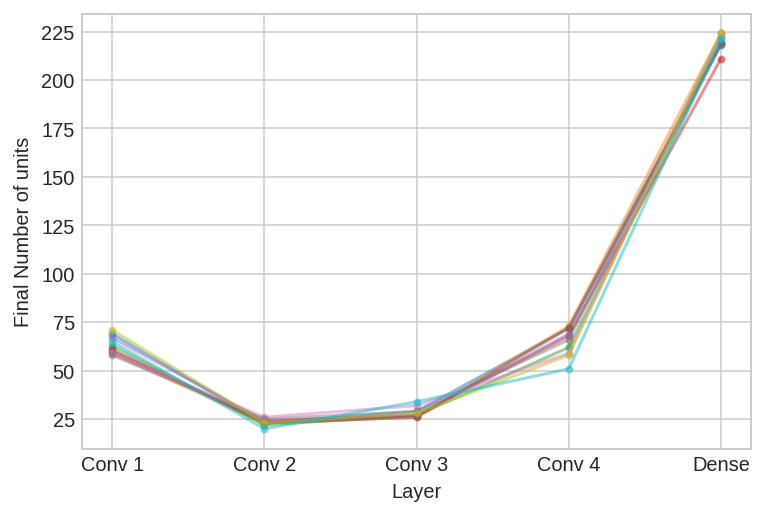

In [93]:
plt.plot(['Conv 1', 'Conv 2', 'Conv 3', 'Conv 4', 'Dense'], final_hidden_layer_sizes_transposed, marker='.', alpha=0.5)
plt.xlabel("Layer")
plt.ylabel("Final Number of units")

## Effects of changing initial hidden layer sizes

In [70]:
%%time

histories = list()
hidden_layer_size_schedule = [25, 50, 75, 100, 125, 150]
for hidden_layer_size in hidden_layer_size_schedule:
    print(f"hidden_layer_size: {hidden_layer_size}")

    batch_size = 128

    layer_sizes = [hidden_layer_size] * 5
    model = get_convolutional_model(cifar100.X_train_norm, regularization_penalty=0.00002, regularization_method='weighted_l1', layer_sizes=layer_sizes, output_neurons=200)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

    schedule = Schedule([EpochType.DYNAMIC] * 20)
    history = model.fit(cifar100.X_train_norm, cifar100.y_train, optimizer, schedule=schedule, batch_size=batch_size, min_new_neurons=20, 
                        validation_data=(cifar100.X_test_norm, cifar100.y_test), growth_percentage=0.2, verbose=False)
    histories.append(history)

hidden_layer_size: 25
hidden_layer_size: 50
hidden_layer_size: 75
hidden_layer_size: 100
hidden_layer_size: 125
hidden_layer_size: 150
CPU times: user 13min 38s, sys: 27.2 s, total: 14min 5s
Wall time: 12min 6s


In [71]:
final_hidden_layer_sizes = list()
for history in histories:
    final_hidden_layer_sizes.append(history['hidden_layer_sizes'][-1])

In [72]:
final_hidden_layer_sizes

[[25, 25, 25, 73, 228],
 [48, 31, 31, 75, 210],
 [63, 26, 28, 70, 212],
 [64, 23, 29, 71, 221],
 [68, 23, 29, 68, 212],
 [58, 22, 26, 68, 218]]

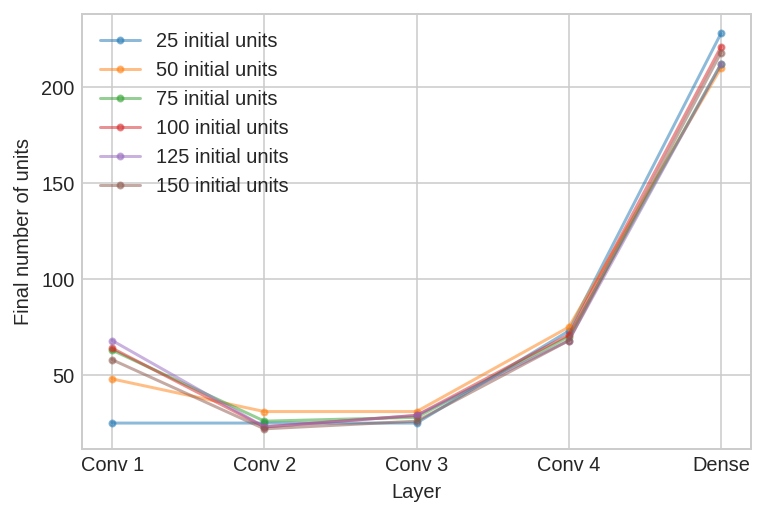

In [89]:
for initial_hidden_layer_size, metric in zip(hidden_layer_size_schedule, final_hidden_layer_sizes):
    label = f"{initial_hidden_layer_size} initial units"
    plt.plot(['Conv 1', 'Conv 2', 'Conv 3', 'Conv 4', 'Dense'], metric, label=label, marker='.', alpha=0.5)
plt.xlabel("Layer")
plt.ylabel("Final number of units")
plt.legend()

In [77]:
evolutions = list()
for history in histories:
    evolutions.append(history['hidden_layer_sizes'])

In [78]:
evolutions

[[[25, 25, 25, 25, 45],
  [25, 25, 25, 27, 65],
  [25, 25, 25, 28, 85],
  [25, 25, 25, 34, 105],
  [25, 25, 25, 36, 126],
  [25, 25, 25, 42, 150],
  [25, 25, 25, 46, 173],
  [25, 25, 25, 53, 191],
  [25, 25, 25, 57, 210],
  [25, 25, 25, 56, 216],
  [25, 25, 26, 60, 217],
  [25, 25, 25, 62, 223],
  [25, 25, 25, 65, 225],
  [25, 25, 25, 70, 224],
  [25, 25, 25, 71, 227],
  [25, 25, 25, 70, 224],
  [25, 25, 25, 75, 224],
  [25, 25, 25, 74, 225],
  [25, 25, 26, 73, 228],
  [25, 25, 25, 73, 228]],
 [[50, 50, 50, 50, 70],
  [50, 50, 50, 51, 90],
  [50, 50, 50, 53, 108],
  [50, 50, 50, 50, 126],
  [50, 50, 50, 51, 146],
  [50, 48, 50, 53, 156],
  [50, 47, 49, 56, 169],
  [50, 45, 49, 59, 185],
  [50, 43, 48, 63, 190],
  [50, 40, 46, 65, 198],
  [50, 39, 45, 62, 200],
  [50, 39, 44, 66, 202],
  [50, 39, 37, 72, 202],
  [50, 35, 36, 72, 205],
  [50, 33, 35, 71, 204],
  [50, 33, 32, 72, 207],
  [49, 33, 34, 75, 207],
  [49, 33, 31, 75, 209],
  [48, 32, 31, 72, 209],
  [48, 31, 31, 75, 210]],
 [[

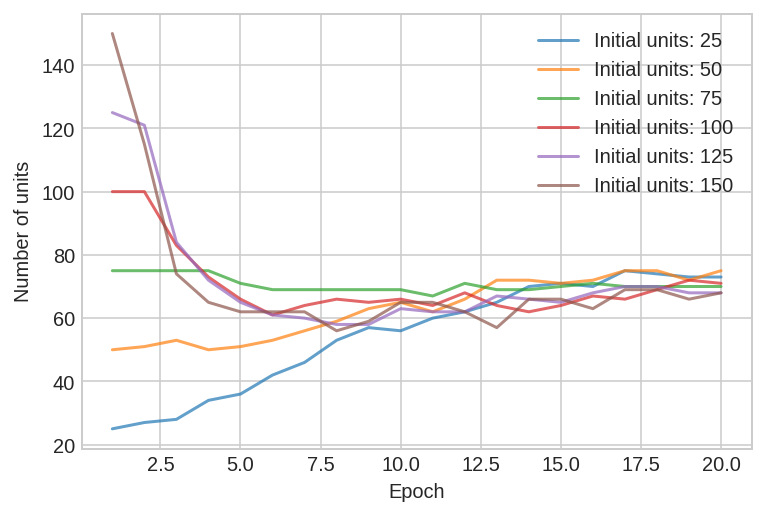

In [94]:
for initial_hidden_layer_size, evolution in zip(hidden_layer_size_schedule, evolutions):
    epochs_list = list(range(1, len(evolution) + 1))
    label = f"Initial units: {initial_hidden_layer_size}"
    evolution_single_layer = [i[3] for i in evolution]
    plt.plot(epochs_list, evolution_single_layer, label=label, alpha=0.7)
plt.xlabel("Epoch")
plt.ylabel("Number of units")
plt.legend()

## Dependency of model size on regularization strength

In [114]:
%%time

histories = list()
regularization_penalties = [0.0002, 0.000063, 0.00002, 0.0000063, 0.000002]
for regularization_penalty in regularization_penalties:
    print(f"regularization_penalty: {regularization_penalty}")

    batch_size = 128

    model = get_convolutional_model(cifar100.X_train_norm, regularization_penalty=regularization_penalty, regularization_method='weighted_l1', layer_sizes=[100, 100, 100, 100, 100], output_neurons=200)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

    schedule = Schedule([EpochType.DYNAMIC] * 20)
    history = model.fit(cifar100.X_train_norm, cifar100.y_train, optimizer, schedule=schedule, batch_size=batch_size, min_new_neurons=20, 
                        validation_data=(cifar100.X_test_norm, cifar100.y_test), growth_percentage=0.2, verbose=False)
    histories.append(history)

regularization_penalty: 0.0002
regularization_penalty: 6.3e-05
regularization_penalty: 2e-05
regularization_penalty: 6.3e-06
regularization_penalty: 2e-06
CPU times: user 15min 14s, sys: 30.7 s, total: 15min 45s
Wall time: 15min 36s


In [115]:
final_hidden_layer_sizes = list()
for history in histories:
    final_hidden_layer_sizes.append(history['hidden_layer_sizes'][-1])

In [116]:
final_hidden_layer_sizes

[[12, 7, 9, 8, 81],
 [32, 11, 19, 15, 109],
 [67, 23, 27, 71, 224],
 [100, 46, 81, 222, 536],
 [136, 136, 263, 589, 1179]]

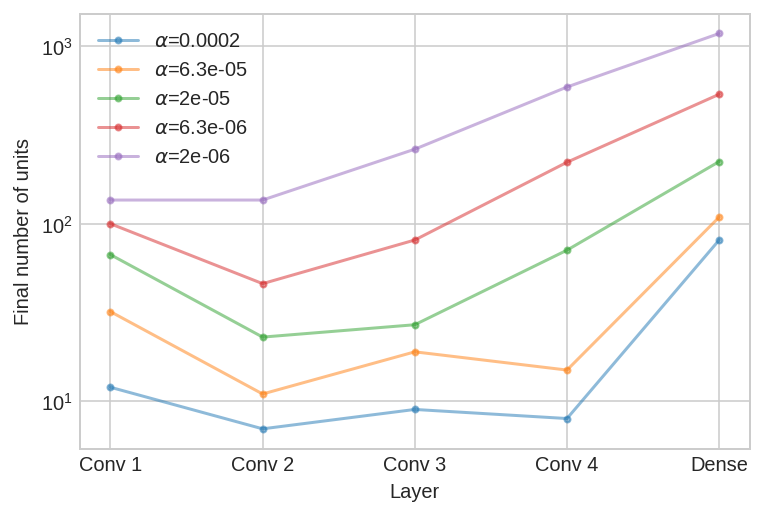

In [117]:
for regularization_penalty, metric in zip(regularization_penalties, final_hidden_layer_sizes):
    label = f"$\\alpha$={regularization_penalty}"
    plt.plot(['Conv 1', 'Conv 2', 'Conv 3', 'Conv 4', 'Dense'], metric, label=label, marker='.', alpha=0.5)
plt.xlabel("Layer")
plt.ylabel("Final number of units")
plt.legend()
plt.yscale('log')

# Legacy code

In [ ]:
%%time

batch_size = 64

model = get_convolutional_model(cifar100.X_train_norm, regularization_penalty=0.00002, regularization_method='weighted_l1', layer_sizes=[100, 100, 100, 100, 100], output_neurons=100)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

history = model.fit(cifar100.X_train_norm, cifar100.y_train, optimizer, epochs=40, self_scaling_epochs=20, batch_size=batch_size, 
                    min_new_neurons=20, validation_data=(cifar100.X_test_norm, cifar100.y_test), pruning_only_epochs=0, 
                    growth_percentage=0.2, verbose=True)

##########################################################
Epoch 1/40
Before growing:
loss: None - accuracy: None - val_loss: 4.954936504364014 - val_accuracy: 0.011 - penalty: 2e-05
hidden layer sizes: [100, 100, 100, 100, 100], total units: 500
After growing:
loss: None - accuracy: None - val_loss: 4.954936504364014 - val_accuracy: 0.011 - penalty: 2e-05
hidden layer sizes: [120, 120, 120, 120, 120], total units: 600
Before pruning:
loss: 3.9630274772644043 - accuracy: 0.11682000011205673 - val_loss: 3.6065542697906494 - val_accuracy: 0.166 - penalty: 2e-05
hidden layer sizes: [120, 120, 120, 120, 120], total units: 600
After pruning:
loss: None - accuracy: None - val_loss: 3.6065804958343506 - val_accuracy: 0.166 - penalty: 2e-05
hidden layer sizes: [100, 100, 100, 100, 107], total units: 507
##########################################################
Epoch 2/40
Before growing:
loss: None - accuracy: None - val_loss: 3.6065804958343506 - val_accuracy: 0.166 - penalty: 2e-05
hidden la

In [ ]:
%%time

histories = hyperparameter_search(train_fn, x=cifar100.X_train_norm, y=cifar100.y_train, validation_data=(cifar100.X_test_norm, cifar100.y_test), 
                                  learning_rate=[0.0002], regularization_penalty=[0.00002], regularization_method=['weighted_l1'], 
                                  self_scaling_epochs=[20], layer_sizes=[[65, 23, 29, 72, 201]], output_neurons=[100], min_new_neurons=[0, 1, 2, 4, 8, 16, 32], growth_percentage=[0.])

Run with parameters (0.0002, 2e-05, 'weighted_l1', 20, [65, 23, 29, 72, 201], 100, 0, 0.0) completed, best_val_accuracy: 0.4445, best_hidden_layer_sizes sizes: [59, 23, 29, 68, 201]
Run with parameters (0.0002, 2e-05, 'weighted_l1', 20, [65, 23, 29, 72, 201], 100, 1, 0.0) completed, best_val_accuracy: 0.4427, best_hidden_layer_sizes sizes: [60, 23, 29, 70, 201]
Run with parameters (0.0002, 2e-05, 'weighted_l1', 20, [65, 23, 29, 72, 201], 100, 2, 0.0) completed, best_val_accuracy: 0.4516, best_hidden_layer_sizes sizes: [62, 23, 29, 65, 203]
Run with parameters (0.0002, 2e-05, 'weighted_l1', 20, [65, 23, 29, 72, 201], 100, 4, 0.0) completed, best_val_accuracy: 0.4449, best_hidden_layer_sizes sizes: [61, 23, 29, 72, 206]
Run with parameters (0.0002, 2e-05, 'weighted_l1', 20, [65, 23, 29, 72, 201], 100, 8, 0.0) completed, best_val_accuracy: 0.4507, best_hidden_layer_sizes sizes: [59, 23, 29, 69, 210]
Run with parameters (0.0002, 2e-05, 'weighted_l1', 20, [65, 23, 29, 72, 201], 100, 16, 0.0

In [ ]:
%%time

histories = hyperparameter_search(train_fn, x=cifar100.X_train_norm, y=cifar100.y_train, validation_data=(cifar100.X_test_norm, cifar100.y_test), 
                                  learning_rate=[0.0002], regularization_penalty=[0.00002], regularization_method=[None, 'weighted_l1'], 
                                  self_scaling_epochs=[0], layer_sizes=[[65, 23, 29, 72, 201]], output_neurons=[100], min_new_neurons=[0], growth_percentage=[0.])

Run with parameters (0.0002, 2e-05, None, 0, [65, 23, 29, 72, 201], 100, 0, 0.0) completed, best_val_accuracy: 0.3236, best_hidden_layer_sizes sizes: [65, 23, 29, 72, 201]
Run with parameters (0.0002, 2e-05, 'weighted_l1', 0, [65, 23, 29, 72, 201], 100, 0, 0.0) completed, best_val_accuracy: 0.3375, best_hidden_layer_sizes sizes: [65, 23, 29, 72, 201]
Best overall combination: (0.0002, 2e-05, 'weighted_l1', 0, [65, 23, 29, 72, 201], 100, 0, 0.0), val_accuracy: 0.3375
CPU times: user 4min 49s, sys: 12.2 s, total: 5min 1s
Wall time: 3min 51s


In [ ]:
%%time

histories = hyperparameter_search(train_fn, x=cifar100.X_train_norm, y=cifar100.y_train, validation_data=(cifar100.X_test_norm, cifar100.y_test), 
                                  learning_rate=[0.0002], regularization_penalty=[0.00002], regularization_method=['weighted_l1'], 
                                  self_scaling_epochs=[20], layer_sizes=[[65, 23, 29, 72, 201]], output_neurons=[100], min_new_neurons=[0], growth_percentage=[0.])

Run with parameters (0.0002, 2e-05, 'weighted_l1', 20, [65, 23, 29, 72, 201], 100, 0, 0.0) completed, best_val_accuracy: 0.4537, best_hidden_layer_sizes sizes: [60, 23, 29, 65, 201]
Best overall combination: (0.0002, 2e-05, 'weighted_l1', 20, [65, 23, 29, 72, 201], 100, 0, 0.0), val_accuracy: 0.4537
CPU times: user 3min 1s, sys: 7.44 s, total: 3min 9s
Wall time: 2min 29s


In [ ]:
%%time

histories = hyperparameter_search(train_fn, x=cifar100.X_train_norm, y=cifar100.y_train, validation_data=(cifar100.X_test_norm, cifar100.y_test), 
                                  learning_rate=[0.0002], regularization_penalty=[0.00002], regularization_method=['weighted_l1'], 
                                  self_scaling_epochs=[0, 20], layer_sizes=[[65, 23, 29, 72, 201]], output_neurons=[100], min_new_neurons=[0], growth_percentage=[0.])

Run with parameters (0.0002, 2e-05, 'weighted_l1', 0, [65, 23, 29, 72, 201], 100, 0, 0.0) completed, best_val_accuracy: 0.3259, best_hidden_layer_sizes sizes: [65, 23, 29, 72, 201]
Run with parameters (0.0002, 2e-05, 'weighted_l1', 20, [65, 23, 29, 72, 201], 100, 0, 0.0) completed, best_val_accuracy: 0.4573, best_hidden_layer_sizes sizes: [61, 23, 29, 62, 200]
Best overall combination: (0.0002, 2e-05, 'weighted_l1', 20, [65, 23, 29, 72, 201], 100, 0, 0.0), val_accuracy: 0.4573
CPU times: user 5min 35s, sys: 14 s, total: 5min 49s
Wall time: 4min 33s


In [ ]:
%%time

schedule = Schedule([EpochType.STATIC_WITH_REGULARIZATION] * 40)
histories = hyperparameter_search(train_fn, x=cifar100.X_train_norm, y=cifar100.y_train, validation_data=(cifar100.X_test_norm, cifar100.y_test), 
                                  learning_rate=[0.0002], schedule=[schedule], regularization_penalty=[0.00002], regularization_method=[None, 'weighted_l1'], 
                                  layer_sizes=[[65, 23, 29, 72, 201]], output_neurons=[100], min_new_neurons=[0], growth_percentage=[0.])

Run with parameters (0.0002, 1111111111111111111111111111111111111111, 2e-05, None, [65, 23, 29, 72, 201], 100, 0, 0.0) completed, best_val_accuracy: 0.3213, best_hidden_layer_sizes sizes: [65, 23, 29, 72, 201]
Run with parameters (0.0002, 1111111111111111111111111111111111111111, 2e-05, 'weighted_l1', [65, 23, 29, 72, 201], 100, 0, 0.0) completed, best_val_accuracy: 0.4173, best_hidden_layer_sizes sizes: [65, 23, 29, 72, 201]
Best overall combination: (0.0002, 1111111111111111111111111111111111111111, 2e-05, 'weighted_l1', [65, 23, 29, 72, 201], 100, 0, 0.0), val_accuracy: 0.4173
CPU times: user 5min 3s, sys: 13.3 s, total: 5min 16s
Wall time: 4min 2s


In [ ]:
%%time

schedule = Schedule([EpochType.STATIC_WITH_REGULARIZATION] * 20 + [EpochType.STATIC_NO_REGULARIZATION] * 20)
histories = hyperparameter_search(train_fn, x=cifar100.X_train_norm, y=cifar100.y_train, validation_data=(cifar100.X_test_norm, cifar100.y_test), 
                                  learning_rate=[0.0002], schedule=[schedule], regularization_penalty=[0.00002], regularization_method=[None, 'weighted_l1'], 
                                  layer_sizes=[[65, 23, 29, 72, 201]], output_neurons=[100], min_new_neurons=[0], growth_percentage=[0.])

Run with parameters (0.0002, 1111111111111111111122222222222222222222, 2e-05, None, [65, 23, 29, 72, 201], 100, 0, 0.0) completed, best_val_accuracy: 0.3227, best_hidden_layer_sizes sizes: [65, 23, 29, 72, 201]
Run with parameters (0.0002, 1111111111111111111122222222222222222222, 2e-05, 'weighted_l1', [65, 23, 29, 72, 201], 100, 0, 0.0) completed, best_val_accuracy: 0.4239, best_hidden_layer_sizes sizes: [65, 23, 29, 72, 201]
Best overall combination: (0.0002, 1111111111111111111122222222222222222222, 2e-05, 'weighted_l1', [65, 23, 29, 72, 201], 100, 0, 0.0), val_accuracy: 0.4239
CPU times: user 4min 56s, sys: 12.7 s, total: 5min 9s
Wall time: 3min 56s


In [ ]:
%%time

schedule = Schedule([EpochType.DYNAMIC] * 20 + [EpochType.STATIC_NO_REGULARIZATION] * 20)
histories = hyperparameter_search(train_fn, x=cifar100.X_train_norm, y=cifar100.y_train, validation_data=(cifar100.X_test_norm, cifar100.y_test), 
                                  learning_rate=[0.0002], schedule=[schedule], regularization_penalty=[0.00002], regularization_method=[None, 'weighted_l1'], 
                                  layer_sizes=[[65, 23, 29, 72, 201]], output_neurons=[100], min_new_neurons=[0], growth_percentage=[0.])

Run with parameters (0.0002, 0000000000000000000022222222222222222222, 2e-05, None, [65, 23, 29, 72, 201], 100, 0, 0.0) completed, best_val_accuracy: 0.3333, best_hidden_layer_sizes sizes: [65, 23, 29, 72, 201]
Run with parameters (0.0002, 0000000000000000000022222222222222222222, 2e-05, 'weighted_l1', [65, 23, 29, 72, 201], 100, 0, 0.0) completed, best_val_accuracy: 0.4584, best_hidden_layer_sizes sizes: [61, 23, 29, 60, 201]
Best overall combination: (0.0002, 0000000000000000000022222222222222222222, 2e-05, 'weighted_l1', [65, 23, 29, 72, 201], 100, 0, 0.0), val_accuracy: 0.4584
CPU times: user 5min 46s, sys: 13.7 s, total: 6min
Wall time: 4min 43s


## L1 regularization

In [ ]:
%%time

schedule = Schedule([EpochType.STATIC_WITH_REGULARIZATION] * 40)
histories = hyperparameter_search(train_fn, x=cifar100.X_train_norm, y=cifar100.y_train, validation_data=(cifar100.X_test_norm, cifar100.y_test), 
                                  learning_rate=[0.0002], schedule=[schedule], regularization_penalty=[0., 0.00002, 0.0002, 0.002, 0.02], regularization_method=['l1'], 
                                  layer_sizes=[[65, 23, 29, 72, 201]], output_neurons=[100], min_new_neurons=[0], growth_percentage=[0.])

Run with parameters (0.0002, 1111111111111111111111111111111111111111, 0.0, 'l1', [65, 23, 29, 72, 201], 100, 0, 0.0) completed, best_val_accuracy: 0.3278, best_hidden_layer_sizes sizes: [65, 23, 29, 72, 201]
Run with parameters (0.0002, 1111111111111111111111111111111111111111, 2e-05, 'l1', [65, 23, 29, 72, 201], 100, 0, 0.0) completed, best_val_accuracy: 0.3348, best_hidden_layer_sizes sizes: [65, 23, 29, 72, 201]
Run with parameters (0.0002, 1111111111111111111111111111111111111111, 0.0002, 'l1', [65, 23, 29, 72, 201], 100, 0, 0.0) completed, best_val_accuracy: 0.4063, best_hidden_layer_sizes sizes: [65, 23, 29, 72, 201]
Run with parameters (0.0002, 1111111111111111111111111111111111111111, 0.002, 'l1', [65, 23, 29, 72, 201], 100, 0, 0.0) completed, best_val_accuracy: 0.2332, best_hidden_layer_sizes sizes: [65, 23, 29, 72, 201]
Run with parameters (0.0002, 1111111111111111111111111111111111111111, 0.02, 'l1', [65, 23, 29, 72, 201], 100, 0, 0.0) completed, best_val_accuracy: 0.0103, 

In [ ]:
%%time

schedule = Schedule([EpochType.STATIC_WITH_REGULARIZATION] * 40)
histories = hyperparameter_search(train_fn, x=cifar100.X_train_norm, y=cifar100.y_train, validation_data=(cifar100.X_test_norm, cifar100.y_test), 
                                  learning_rate=[0.0002], schedule=[schedule], regularization_penalty=[0.00005, 0.0001, 0.0002, 0.0004, 0.0008], regularization_method=['l1'], 
                                  layer_sizes=[[65, 23, 29, 72, 201]], output_neurons=[100], min_new_neurons=[0], growth_percentage=[0.])

Run with parameters (0.0002, 1111111111111111111111111111111111111111, 5e-05, 'l1', [65, 23, 29, 72, 201], 100, 0, 0.0) completed, best_val_accuracy: 0.3447, best_hidden_layer_sizes sizes: [65, 23, 29, 72, 201]
Run with parameters (0.0002, 1111111111111111111111111111111111111111, 0.0001, 'l1', [65, 23, 29, 72, 201], 100, 0, 0.0) completed, best_val_accuracy: 0.3606, best_hidden_layer_sizes sizes: [65, 23, 29, 72, 201]
Run with parameters (0.0002, 1111111111111111111111111111111111111111, 0.0002, 'l1', [65, 23, 29, 72, 201], 100, 0, 0.0) completed, best_val_accuracy: 0.4194, best_hidden_layer_sizes sizes: [65, 23, 29, 72, 201]
Run with parameters (0.0002, 1111111111111111111111111111111111111111, 0.0004, 'l1', [65, 23, 29, 72, 201], 100, 0, 0.0) completed, best_val_accuracy: 0.4177, best_hidden_layer_sizes sizes: [65, 23, 29, 72, 201]
Run with parameters (0.0002, 1111111111111111111111111111111111111111, 0.0008, 'l1', [65, 23, 29, 72, 201], 100, 0, 0.0) completed, best_val_accuracy: 0.

In [ ]:
%%time

schedule = Schedule([EpochType.STATIC_WITH_REGULARIZATION] * 40)
histories = hyperparameter_search(train_fn, x=cifar100.X_train_norm, y=cifar100.y_train, validation_data=(cifar100.X_test_norm, cifar100.y_test), 
                                  learning_rate=[0.0002], schedule=[schedule], regularization_penalty=[0.0003], regularization_method=['l1'], 
                                  layer_sizes=[[65, 23, 29, 72, 201]], output_neurons=[100], min_new_neurons=[0], growth_percentage=[0.])

Run with parameters (0.0002, 1111111111111111111111111111111111111111, 0.0003, 'l1', [65, 23, 29, 72, 201], 100, 0, 0.0) completed, best_val_accuracy: 0.4293, best_hidden_layer_sizes sizes: [65, 23, 29, 72, 201]
Best overall combination: (0.0002, 1111111111111111111111111111111111111111, 0.0003, 'l1', [65, 23, 29, 72, 201], 100, 0, 0.0), val_accuracy: 0.4293
CPU times: user 2min 33s, sys: 7.19 s, total: 2min 40s
Wall time: 2min 2s


In [ ]:
%%time

schedule = Schedule([EpochType.STATIC_WITH_REGULARIZATION] * 40)
histories = hyperparameter_search(train_fn, x=cifar100.X_train_norm, y=cifar100.y_train, validation_data=(cifar100.X_test_norm, cifar100.y_test), 
                                  learning_rate=[0.0002], schedule=[schedule], regularization_penalty=[0.0002, 0.0003, 0.0004], regularization_method=['l1'], 
                                  layer_sizes=[[66, 66, 66, 66, 201]], output_neurons=[100], min_new_neurons=[0], growth_percentage=[0.])

Run with parameters (0.0002, 1111111111111111111111111111111111111111, 0.0002, 'l1', [66, 66, 66, 66, 201], 100, 0, 0.0) completed, best_val_accuracy: 0.4416, best_hidden_layer_sizes sizes: [66, 66, 66, 66, 201]
Run with parameters (0.0002, 1111111111111111111111111111111111111111, 0.0003, 'l1', [66, 66, 66, 66, 201], 100, 0, 0.0) completed, best_val_accuracy: 0.4535, best_hidden_layer_sizes sizes: [66, 66, 66, 66, 201]
Run with parameters (0.0002, 1111111111111111111111111111111111111111, 0.0004, 'l1', [66, 66, 66, 66, 201], 100, 0, 0.0) completed, best_val_accuracy: 0.441, best_hidden_layer_sizes sizes: [66, 66, 66, 66, 201]
Best overall combination: (0.0002, 1111111111111111111111111111111111111111, 0.0003, 'l1', [66, 66, 66, 66, 201], 100, 0, 0.0), val_accuracy: 0.4535
CPU times: user 8min, sys: 17.1 s, total: 8min 17s
Wall time: 7min 14s


In [ ]:
%%time

batch_size = 128

model = get_convolutional_model(cifar100.X_train_norm, regularization_penalty=0.00002, regularization_method=None, layer_sizes=[65, 23, 29, 72, 201], output_neurons=100)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

history = model.fit(cifar100.X_train_norm, cifar100.y_train, optimizer, epochs=40, self_scaling_epochs=20, batch_size=batch_size, 
                    min_new_neurons=0, validation_data=(cifar100.X_test_norm, cifar100.y_test), pruning_only_epochs=0, 
                    growth_percentage=0., verbose=True)

##########################################################
Epoch 1/40
Before growing:
loss: None - accuracy: None - val_loss: 5.157856464385986 - val_accuracy: 0.0083 - penalty: 2e-05
hidden layer sizes: [65, 23, 29, 72, 201], total units: 390
After growing:
loss: None - accuracy: None - val_loss: 5.157856464385986 - val_accuracy: 0.0083 - penalty: 2e-05
hidden layer sizes: [65, 23, 29, 72, 201], total units: 390
Before pruning:
loss: 4.065201759338379 - accuracy: 0.10670000314712524 - val_loss: 3.5247750282287598 - val_accuracy: 0.1916 - penalty: 2e-05
hidden layer sizes: [65, 23, 29, 72, 201], total units: 390
After pruning:
loss: None - accuracy: None - val_loss: 3.5247750282287598 - val_accuracy: 0.1916 - penalty: 2e-05
hidden layer sizes: [65, 23, 29, 72, 201], total units: 390
##########################################################
Epoch 2/40
Before growing:
loss: None - accuracy: None - val_loss: 3.5247750282287598 - val_accuracy: 0.1916 - penalty: 2e-05
hidden layer sizes: [

## Test - Tiny ImageNet

In [ ]:
tiny_imagenet = get_tiny_imagenet_dataset()

Processing the downloaded dataset...


In [ ]:
%%time

batch_size = 64

model = get_convolutional_model(tiny_imagenet.X_train_norm, regularization_penalty=0.00002, regularization_method='weighted_l1', layer_sizes=[100, 100, 100, 100, 100], output_neurons=200)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

schedule = Schedule([EpochType.DYNAMIC] * 20 + [EpochType.STATIC_NO_REGULARIZATION] * 20)
history = model.fit(tiny_imagenet.X_train_norm, tiny_imagenet.y_train, optimizer, schedule=schedule, batch_size=batch_size, min_new_neurons=20, 
                    validation_data=(tiny_imagenet.X_test_norm, tiny_imagenet.y_test), growth_percentage=0.2, verbose=True)

##########################################################
Epoch 1/40
Before growing:
loss: None - accuracy: None - val_loss: 5.541385173797607 - val_accuracy: 0.0073 - penalty: 2e-05
hidden layer sizes: [100, 100, 100, 100, 100], total units: 500
After growing:
loss: None - accuracy: None - val_loss: 5.541385173797607 - val_accuracy: 0.0073 - penalty: 2e-05
hidden layer sizes: [120, 120, 120, 120, 120], total units: 600
Before pruning:
loss: 4.205804824829102 - accuracy: 0.1064400002360344 - val_loss: 5.56486701965332 - val_accuracy: 0.0509 - penalty: 2e-05
hidden layer sizes: [120, 120, 120, 120, 120], total units: 600
After pruning:
loss: None - accuracy: None - val_loss: 5.564840793609619 - val_accuracy: 0.0509 - penalty: 2e-05
hidden layer sizes: [100, 100, 100, 98, 120], total units: 518
##########################################################
Epoch 2/40
Before growing:
loss: None - accuracy: None - val_loss: 5.564840793609619 - val_accuracy: 0.0509 - penalty: 2e-05
hidden laye

In [ ]:
%%time

batch_size = 64

model = get_convolutional_model(tiny_imagenet.X_train_norm, regularization_penalty=0.00002, regularization_method='weighted_l1', layer_sizes=[100, 100, 100, 100, 100, 100], output_neurons=200)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

schedule = Schedule([EpochType.DYNAMIC] * 20 + [EpochType.STATIC_NO_REGULARIZATION] * 20)
history = model.fit(tiny_imagenet.X_train_norm, tiny_imagenet.y_train, optimizer, schedule=schedule, batch_size=batch_size, min_new_neurons=20, 
                    validation_data=(tiny_imagenet.X_test_norm, tiny_imagenet.y_test), growth_percentage=0.2, verbose=True)

##########################################################
Epoch 1/40
Before growing:
loss: None - accuracy: None - val_loss: 5.5959930419921875 - val_accuracy: 0.0045 - penalty: 2e-05
hidden layer sizes: [100, 100, 100, 100, 100, 100], total units: 600
After growing:
loss: None - accuracy: None - val_loss: 5.595992565155029 - val_accuracy: 0.0045 - penalty: 2e-05
hidden layer sizes: [120, 120, 120, 120, 120, 120], total units: 720
Before pruning:
loss: 4.2364702224731445 - accuracy: 0.10057999938726425 - val_loss: 5.51335334777832 - val_accuracy: 0.0425 - penalty: 2e-05
hidden layer sizes: [120, 120, 120, 120, 120, 120], total units: 720
After pruning:
loss: None - accuracy: None - val_loss: 5.513298511505127 - val_accuracy: 0.0425 - penalty: 2e-05
hidden layer sizes: [100, 100, 100, 100, 100, 119], total units: 619
##########################################################
Epoch 2/40
Before growing:
loss: None - accuracy: None - val_loss: 5.513298511505127 - val_accuracy: 0.0425 - pe

In [ ]:
%%time

batch_size = 64

model = get_convolutional_model(tiny_imagenet.X_train_norm, regularization_penalty=0.0002, regularization_method='l1', layer_sizes=[48, 12, 17, 19, 77, 296], output_neurons=200)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

schedule = Schedule([EpochType.STATIC_WITH_REGULARIZATION] * 40)
history = model.fit(tiny_imagenet.X_train_norm, tiny_imagenet.y_train, optimizer, schedule=schedule, batch_size=batch_size, min_new_neurons=20, 
                    validation_data=(tiny_imagenet.X_test_norm, tiny_imagenet.y_test), growth_percentage=0.2, verbose=True)

##########################################################
Epoch 1/40
loss: 4.289374828338623 - accuracy: 0.09640000015497208 - val_loss: 5.259166717529297 - val_accuracy: 0.0573 - penalty: 0.0002
hidden layer sizes: [48, 12, 17, 19, 77, 296], total units: 469
##########################################################
Epoch 2/40
loss: 3.8369767665863037 - accuracy: 0.15317000448703766 - val_loss: 5.067516803741455 - val_accuracy: 0.0667 - penalty: 0.0002
hidden layer sizes: [48, 12, 17, 19, 77, 296], total units: 469
##########################################################
Epoch 3/40
loss: 3.6995861530303955 - accuracy: 0.17618000507354736 - val_loss: 5.2216477394104 - val_accuracy: 0.0671 - penalty: 0.0002
hidden layer sizes: [48, 12, 17, 19, 77, 296], total units: 469
##########################################################
Epoch 4/40
loss: 3.60565185546875 - accuracy: 0.18990999460220337 - val_loss: 4.899083614349365 - val_accuracy: 0.0808 - penalty: 0.0002
hidden layer sizes: [

In [ ]:
%%time

batch_size = 64

model = get_convolutional_model(tiny_imagenet.X_train_norm, regularization_penalty=0.00002, regularization_method='weighted_l1', layer_sizes=[100, 100, 100, 100, 100, 100], output_neurons=200)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

schedule = Schedule([EpochType.DYNAMIC] * 30 + [EpochType.STATIC_NO_REGULARIZATION] * 30)
history = model.fit(tiny_imagenet.X_train_norm, tiny_imagenet.y_train, optimizer, schedule=schedule, batch_size=batch_size, min_new_neurons=20, 
                    validation_data=(tiny_imagenet.X_test_norm, tiny_imagenet.y_test), growth_percentage=0.2, verbose=True)

##########################################################
Epoch 1/60
Before growing:
loss: None - accuracy: None - val_loss: 5.558587074279785 - val_accuracy: 0.0039 - penalty: 2e-05
hidden layer sizes: [100, 100, 100, 100, 100, 100], total units: 600
After growing:
loss: None - accuracy: None - val_loss: 5.558587074279785 - val_accuracy: 0.0039 - penalty: 2e-05
hidden layer sizes: [120, 120, 120, 120, 120, 120], total units: 720
Before pruning:
loss: 4.259202003479004 - accuracy: 0.09923999756574631 - val_loss: 5.461585998535156 - val_accuracy: 0.0431 - penalty: 2e-05
hidden layer sizes: [120, 120, 120, 120, 120, 120], total units: 720
After pruning:
loss: None - accuracy: None - val_loss: 5.461586952209473 - val_accuracy: 0.0431 - penalty: 2e-05
hidden layer sizes: [100, 100, 100, 100, 100, 120], total units: 620
##########################################################
Epoch 2/60
Before growing:
loss: None - accuracy: None - val_loss: 5.461586952209473 - val_accuracy: 0.0431 - pen

In [ ]:
%%time

batch_size = 64

model = get_convolutional_model(tiny_imagenet.X_train_norm, regularization_penalty=0.0002, regularization_method='l1', layer_sizes=[37, 11, 19, 20, 86, 310], output_neurons=200)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

schedule = Schedule([EpochType.STATIC_WITH_REGULARIZATION] * 60)
history = model.fit(tiny_imagenet.X_train_norm, tiny_imagenet.y_train, optimizer, schedule=schedule, batch_size=batch_size, min_new_neurons=20, 
                    validation_data=(tiny_imagenet.X_test_norm, tiny_imagenet.y_test), growth_percentage=0.2, verbose=True)

##########################################################
Epoch 1/60
loss: 4.257846355438232 - accuracy: 0.0994499996304512 - val_loss: 5.318850994110107 - val_accuracy: 0.0526 - penalty: 0.0002
hidden layer sizes: [37, 11, 19, 20, 86, 310], total units: 483
##########################################################
Epoch 2/60
loss: 3.785670518875122 - accuracy: 0.16226999461650848 - val_loss: 5.088986396789551 - val_accuracy: 0.0651 - penalty: 0.0002
hidden layer sizes: [37, 11, 19, 20, 86, 310], total units: 483
##########################################################
Epoch 3/60
loss: 3.666051149368286 - accuracy: 0.17880000174045563 - val_loss: 5.0565667152404785 - val_accuracy: 0.0699 - penalty: 0.0002
hidden layer sizes: [37, 11, 19, 20, 86, 310], total units: 483
##########################################################
Epoch 4/60
loss: 3.5895581245422363 - accuracy: 0.19134999811649323 - val_loss: 5.020029544830322 - val_accuracy: 0.0803 - penalty: 0.0002
hidden layer sizes: